In [90]:
# !pip install pytorch
# !pip install datasets

import math
import random
from bs4 import BeautifulSoup
import re
import pandas as pd
from datasets import load_dataset
import numpy as np
import itertools
from collections import Counter
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score


from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [91]:
# def StringToInteger(Value):
#     try:
#         Val = int(Value)
#         if Val in range(1, 6, 1):
#             return Val
#         else:
#             return -1
#     except ValueError:
#         return 0

# Data = pd.read_csv('data.tsv', sep='\t', on_bad_lines='skip', low_memory=False)
# Data = Data.loc[:, ['star_rating', 'review_body']]
# Data.rename(columns={'star_rating': 'Rating','review_body': 'Review'}, inplace=True)

# Data['Rating'] = Data['Rating'].apply(StringToInteger)
# Data = Data[Data['Rating'] != -1]

# Data = Data.dropna(subset=['Review'])
# Data.reset_index(drop=True, inplace=True)
# Data['Review'] = Data['Review'].apply(str)

# Data['Class'] = Data['Rating'].apply(lambda x: 0 if x <= 3 else 1)
# Class0 = Data[Data['Class'] == 0].sample(
#     500, random_state=random.randint(1, 100), ignore_index=True)
# Class1 = Data[Data['Class'] == 1].sample(
#     500, random_state=random.randint(1, 100), ignore_index=True)

# Data = pd.concat([Class0, Class1], ignore_index=True)
# Data = Data.sample(frac=1, random_state=random.randint(
#     1, 100), ignore_index=True)

# def clean(Reviews):
#     Result = []
#     for Review in Reviews:
#         # Review = Review.lower()
#         Review = BeautifulSoup(Review, 'html.parser').get_text()
#         Review = re.sub(r'[^a-zA-Z\s]', '', Review)
#         Review = re.sub(r'\s+', ' ', Review).strip()

#         Result.append(Review)
#     return Result
# def tokenize(Reviews):
#     Result = []
#     stop=set(stopwords.words('english'))
#     for Review in Reviews:
#         words = word_tokenize(Review)
#         words = [word for word in words if word not in stop]
#         Result.append(words)
#     return Result
# Data['Review'] = clean(Data['Review'])
# Data['Tokens']= tokenize(Data['Review'])
# Data.to_csv('Data.csv', index=False)

In [92]:
Data=pd.read_csv('Data.csv')

In [93]:
Data['Tokens']=Data['Tokens'].apply(eval)
tokens=[]
for token in Data['Tokens']:
    tokens.extend(token)
# WORDS MAP
word_frequency = Counter(tokens)

word_frequency = {
    word: frequency
    for word, frequency in word_frequency.items()
    if frequency >= 3
}
word2idx = {
    word: index
    for index, word in enumerate(word_frequency.keys(), start=2)
}
word2idx['<pad>'] = 0
word2idx['<unk>'] = 1


idx2word = {index: word for word, index in word2idx.items()}
vocab = list(word2idx.keys())
vocab_size = len(vocab)

Data['Ids'] = Data['Tokens'].apply(
    lambda tokens: [word2idx[word] if word in vocab else 1 for word in tokens ])

In [94]:
# Split data frame into train, validation and test
train = Data.sample(frac=0.8, random_state=random.randint(1, 100))
test = Data.drop(train.index)
dev = train.sample(frac=0.2, random_state=random.randint(1, 100))
train = train.drop(dev.index)

## GLOVE EMBEDDINGS


## Data Loader

In [95]:
def combine_masks(sequence):
    cm =[int(word[0].isupper()) for word in sequence]
    um = [int(word.isupper()) for word in sequence]
    lm = [int(word.islower()) for word in sequence]
    mm = [int(not word.islower() and not word.isupper()) for word in sequence]
    return [
        [cm[i],um[i],lm[i],mm[i]] for i in range(len(cm))
    ]

class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data.iloc[idx]
        input_ids = sample['Ids']
        lengths = len(input_ids)
        label = sample['Class']
        return input_ids,lengths,label


def custom_collate_fn(batch):
    input_ids,lengths, label = zip(*batch)
    max_seq_length = max(lengths)

    padded_input_ids = [seq + [0] * (max_seq_length - len(seq)) for seq in input_ids]

    input_ids = torch.tensor(padded_input_ids, dtype=torch.long )
    lengths = torch.tensor(lengths, dtype=torch.float )
    label = torch.tensor(label, dtype=torch.long )
    return input_ids,lengths,label

batch_size = 2

train_dataset = CustomDataset(train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)

dev_dataset=CustomDataset(dev)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)

test_dataset=CustomDataset(test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)

In [96]:
# for batch in train_loader:
#     input_ids,lengths, label = batch
#     print(input_ids)
#     print(lengths)
#     print(label)
#     print(input_ids.shape)
#     print(lengths.shape)
#     print(label.shape)
#     break

In [97]:
glove_file = "glove.6B.100d"
glove_embeddings = {}
with open(glove_file, "r", encoding="utf-8") as f:
    for line in f:
        values = line.strip().split()
        word = values[0]
        vector = np.array(values[1:], dtype=np.float32)
        glove_embeddings[word] = vector

embedding_dim = 100
glove_embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word,i in word2idx.items():
    if word.lower() in glove_embeddings:
        glove_embedding_matrix[i] = glove_embeddings[word.lower()]
    else:
        glove_embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim, ))

glove_embedding_matrix = torch.Tensor(glove_embedding_matrix).float()

In [98]:
def train_model(model,criterion,optimizer,train_loader,val_loader,num_epochs,model_path):
    train_loss = []
    val_loss = []
    best_val_loss = 100
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch in train_loader:
            inputs,lengths, labels = batch  
            outputs = model(inputs,lengths)
            optimizer.zero_grad()
            outputs = model(inputs, lengths)
            loss = criterion(outputs.squeeze(), labels.view(-1).float())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader)
        train_loss.append(epoch_loss)
        # print(f"Epoch {epoch} training loss: {epoch_loss}")
        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                inputs,lengths, labels = batch  
                outputs = model(inputs,lengths)
                loss = criterion(outputs.squeeze(), labels.view(-1).float())
                running_loss += loss.item()
            epoch_loss = running_loss / len(val_loader)
            val_loss.append(epoch_loss)
            # print(f"Epoch {epoch} validation loss: {epoch_loss}")
            if epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                torch.save(model.state_dict(), model_path)
    return train_loss, val_loss

def test_model(model,test_loader):
    y_pred = []
    y_true = []
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            inputs,lengths, labels = batch
            outputs = model(inputs,lengths)
            predictions = (outputs >= 0.5).int().squeeze()
            y_pred.extend(predictions.tolist())
            y_true.extend(labels.tolist())
    return y_true, y_pred

In [99]:
class Model1(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim,glove_embedding_matrix):
        super(Model1, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(glove_embedding_matrix,freeze=True)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(0.5)
        self.sigmoid = nn.Sigmoid()

    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        packed_embedded = pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True,enforce_sorted=False)
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        hidden = self.dropout(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1))
        logits=self.fc(hidden)
        return self.sigmoid(logits)

model1 = Model1(vocab_size, embedding_dim, 128, 1,glove_embedding_matrix)
model1 = model1.to(device)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.BCELoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001)

train_loss, val_loss = train_model(model1,criterion,optimizer,train_loader,dev_loader,5,'./model1.pt')

model1.load_state_dict(torch.load('./model1.pt'))
y_true, y_pred = test_model(model1,test_loader)

print("accuracy_score: ",accuracy_score(y_true, y_pred))

accuracy_score:  0.72


In [111]:
model2 = Model1(vocab_size, embedding_dim, 64, 1,glove_embedding_matrix)
model2 = model2.to(device)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.BCELoss()
optimizer = optim.Adam(model2.parameters(), lr=0.001)

train_loss2, val_loss2 = train_model(model2,criterion,optimizer,train_loader,dev_loader,5,'./model2.pt')

model2.load_state_dict(torch.load('./model2.pt'))
y_true, y_pred = test_model(model2,test_loader)

print("accuracy_score: ",accuracy_score(y_true, y_pred))

accuracy_score:  0.765


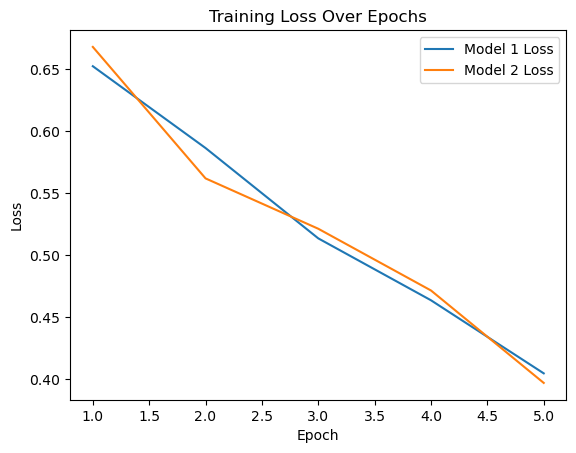

In [114]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(train_loss)+1), train_loss, label='Model 1 Loss')
plt.plot(range(1, len(train_loss2)+1), train_loss2, label='Model 2 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

In [ ]:
models = [model1, model2]


In [ ]:
from torch.functional import F
class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim,glove_embedding_matrix):
        super(SentimentRNN, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(glove_embedding_matrix,freeze=True)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(0.5)

    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        packed_embedded = pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True)
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        output, output_lengths = pad_packed_sequence(packed_output, batch_first=True)
        hidden = self.dropout(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1))
        logits=self.fc(hidden)
        print("Logits",logits)
        return torch.argmax(logits, dim=1)

model = SentimentRNN(vocab_size, embedding_dim, 128, 2,glove_embedding_matrix)
model = model.to(device)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

patience=0
best_dev_loss = float('inf')
for epoch in range(50):
    training_loss = 0.0
    for batch in train_loader:
        input_ids, label = batch
        input_ids = input_ids.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        output = model(input_ids, torch.ones(input_ids.shape[0]).long().to(device))
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        training_loss += loss.item() * input_ids.size(0)
        break
    training_loss /= len(train_loader.dataset)

    dev_loss = 0.0
    for batch in dev_loader:
        input_ids, label = batch
        input_ids = input_ids.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        output = model(input_ids, torch.ones(input_ids.shape[0]).long().to(device))
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        dev_loss += loss.item() * input_ids.size(0)
    dev_loss /= len(dev_loader.dataset)
    print(f'Epoch: {epoch + 1}\nTrain loss:{training_loss}\tDev loss:{dev_loss}')
    # print 3 decimal places

    if(dev_loss<best_dev_loss):
        best_dev_loss=dev_loss
        torch.save(model.state_dict(), 'model.pt')
        patience=0
    else:
        patience+=1
        if(patience==3):
            break    
    correct = 0
    for batch in test_loader:
        input_ids, label = batch
        input_ids = input_ids.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        output = model(input_ids, torch.ones(input_ids.shape[0]).long().to(device))
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(label.view_as(pred)).sum().item()
    accuracy = correct / len(test_loader.dataset)
    max_acc = max(max_acc, accuracy)

print(f'Accuracy: {max_acc * 100:.2f}%')

ValueError: too many values to unpack (expected 2)

In [ ]:
# class SentimentRNN(nn.Module):
#     def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim,glove_embedding_matrix):
#         super(SentimentRNN, self).__init__()
#         self.embedding = nn.Embedding.from_pretrained(glove_embedding_matrix,freeze=True)
#         self.rnn = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, batch_first=True)
#         self.fc = nn.Linear(hidden_dim * 2, output_dim)
#         self.dropout = nn.Dropout(0.5)

#     def forward(self, text, text_lengths):
#         embedded = self.embedding(text)
#         packed_embedded = pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True,enforce_sorted=False)
#         packed_output, (hidden, cell) = self.rnn(packed_embedded)
#         output, output_lengths = pad_packed_sequence(packed_output, batch_first=True)
#         hidden = self.dropout(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1))
#         logits=self.fc(hidden)
#         return torch.argmax(logits, dim=1)

# model = SentimentRNN(vocab_size, embedding_dim, 128, 2,glove_embedding_matrix)
# model = model.to(device)
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# criterion = nn.BCELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# patience = 4
# max_acc = 0
# best_dev_loss = float('inf')
# for epoch in range(50):
#     training_loss = 0.0
#     for batch in train_loader:
#         input_ids,lengths, label = batch
#         input_ids = input_ids.to(device)
#         lengths = lengths.to(device)
#         label = label.to(device)
#         optimizer.zero_grad()

#         output = model(input_ids, lengths)
#         print(label)
#         print(output)
#         loss = criterion(output, label.view(-1))
#         loss.backward()
#         optimizer.step()
#         training_loss += loss.item() * input_ids.size(0)
#     training_loss /= len(train_loader.dataset)

#     dev_loss = 0.0
#     for batch in dev_loader:
#         input_ids, label = batch
#         input_ids = input_ids.to(device)
#         label = label.to(device)
#         optimizer.zero_grad()
#         output = model(input_ids, torch.ones(input_ids.shape[0]).long().to(device))
#         loss = criterion(output, label)
#         loss.backward()
#         optimizer.step()
#         dev_loss += loss.item() * input_ids.size(0)
#     dev_loss /= len(dev_loader.dataset)
#     # print(f'Epoch: {epoch + 1}\nTrain loss:{training_loss}\tDev loss:{dev_loss}')
#     # print 3 decimal places

#     if(dev_loss<best_dev_loss):
#         best_dev_loss=dev_loss
#         torch.save(model.state_dict(), 'model.pt')
#         patience=0
#     else:
#         patience+=1
#         if(patience==3):
#             break    
#     correct = 0
#     for batch in test_loader:
#         input_ids, label = batch
#         input_ids = input_ids.to(device)
#         label = label.to(device)
#         optimizer.zero_grad()
#         output = model(input_ids, torch.ones(input_ids.shape[0]).long().to(device))
#         pred = output.argmax(dim=1, keepdim=True)
#         correct += pred.eq(label.view_as(pred)).sum().item()
#     accuracy = correct / len(test_loader.dataset)
#     # print(f'Accuracy: {accuracy * 100:.2f}%')
#     if accuracy>max_acc:
#         max_acc=accuracy
# print(f'Accuracy: {max_acc * 100:.2f}%')

tensor([0, 0])
tensor([1, 0])


RuntimeError: "binary_cross_entropy" not implemented for 'Long'

In [ ]:
# class M2(nn.Module):
#     def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim,glove_embedding_matrix):
#         super(M2, self).__init__()
#         self.embedding = nn.Embedding.from_pretrained(glove_embedding_matrix,freeze=True)
#         self.bilstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, batch_first=True)
#         self.fc = nn.Linear(hidden_dim * 2, output_dim)
#         self.dropout = nn.Dropout(0.5)

#     def forward(self, text, text_lengths):
#         embedded = self.embedding(text)
#         packed_embedded = pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True)
#         packed_output, (hidden, cell) = self.bilstm(packed_embedded)
#         output, output_lengths = pad_packed_sequence(packed_output, batch_first=True)
#         hidden = self.dropout(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1))
#         return self.fc(hidden)

# model2 = M2(vocab_size, embedding_dim, 128, 2,glove_embedding_matrix)
# model2 = model2.to(device)
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model2.parameters(), lr=0.001)

# patience=4
# max_acc = 0
# best_dev_loss = float('inf')
# for epoch in range(50):
    
#     training_loss = 0.0
#     for batch in train_loader:
#         input_ids, label = batch
#         input_ids = input_ids.to(device)
#         label = label.to(device)
#         optimizer.zero_grad()
#         output = model2(input_ids, torch.ones(input_ids.shape[0]).long().to(device))
#         loss = criterion(output, label)
#         loss.backward()
#         optimizer.step()
#         training_loss += loss.item() * input_ids.size(0)
#     training_loss /= len(train_loader.dataset)

#     dev_loss = 0.0
#     for batch in dev_loader:
#         input_ids, label = batch
#         input_ids = input_ids.to(device)
#         label = label.to(device)
#         optimizer.zero_grad()
#         output = model2(input_ids, torch.ones(input_ids.shape[0]).long().to(device))
#         loss = criterion(output, label)
#         loss.backward()
#         optimizer.step()
#         dev_loss += loss.item() * input_ids.size(0)
#     dev_loss /= len(dev_loader.dataset)
#     # print(f'Epoch: {epoch + 1}\nTrain loss:{training_loss}\tDev loss:{dev_loss}')
#     # print 3 decimal places

#     if(dev_loss<best_dev_loss):
#         best_dev_loss=dev_loss
#         torch.save(model2.state_dict(), 'model2.pt')
#         patience=0
#     else:
#         patience+=1
#         if(patience==3):
#             break    
#     correct = 0
#     for batch in test_loader:
#         input_ids, label = batch
#         input_ids = input_ids.to(device)
#         label = label.to(device)
#         optimizer.zero_grad()
#         output = model(input_ids, torch.ones(input_ids.shape[0]).long().to(device))
        
#         pred = output.argmax(dim=1, keepdim=True)
        
#         correct += pred.eq(label.view_as(pred)).sum().item()
#     accuracy = correct / len(test_loader.dataset)
#     # print(f'Accuracy: {accuracy * 100:.2f}%')
#     if accuracy>max_acc:
#         max_acc=accuracy
# print(f'Accuracy: {max_acc * 100:.2f}%')

tensor([[-0.1170,  0.1272],
        [-0.1706,  0.1796]], grad_fn=<AddmmBackward0>)
tensor([[1],
        [1]])
tensor([[ 0.4035, -0.5284],
        [ 0.2190, -0.3059]], grad_fn=<AddmmBackward0>)
tensor([[0],
        [0]])
tensor([[ 0.3123, -0.4037],
        [ 1.2008, -1.3690]], grad_fn=<AddmmBackward0>)
tensor([[0],
        [0]])
tensor([[-0.0301, -0.3663],
        [ 0.8541, -0.9087]], grad_fn=<AddmmBackward0>)
tensor([[0],
        [0]])
tensor([[ 0.4417, -0.6363],
        [-0.0867,  0.1878]], grad_fn=<AddmmBackward0>)
tensor([[0],
        [1]])
tensor([[ 0.5764, -0.7566],
        [-1.0175,  0.8983]], grad_fn=<AddmmBackward0>)
tensor([[0],
        [1]])
tensor([[ 0.3150, -0.5115],
        [-1.0554,  0.8278]], grad_fn=<AddmmBackward0>)
tensor([[0],
        [1]])
tensor([[ 0.2605, -0.4227],
        [ 0.9071, -0.9531]], grad_fn=<AddmmBackward0>)
tensor([[0],
        [0]])
tensor([[-0.0419, -0.2573],
        [ 0.0842, -0.3626]], grad_fn=<AddmmBackward0>)
tensor([[0],
        [0]])
tensor([[ 

In [ ]:
models = [model, model2]
accuracy = [60.5, 61.5]
correct = [0,0]
criterion =[nn.CrossEntropyLoss(),nn.CrossEntropyLoss()]
optimizer = [optim.Adam(model.parameters(), lr=0.001),optim.Adam(model2.parameters(), lr=0.001)]
for batch in train_loader:
    input_ids, label = batch
    input_ids = input_ids.to(device)
    label = label.to(device)
    for opt in optimizer:
        opt.zero_grad()
        
    outputs = [model(input_ids, torch.ones(input_ids.shape[0]).long().to(device)) for model in models]
    preds = [output.argmax(dim=1, keepdim=True) for output in outputs]
    print(output)
    print(preds)
    for i in range(len(preds)):
        correct[i] += preds[i].eq(label.view_as(preds[i])).sum().item()
    break
accuracy = [c / len(dev_loader.dataset) for c in correct]

tensor([[-0.2148,  0.2339],
        [ 0.5634, -0.1709]], grad_fn=<AddmmBackward0>)
[tensor([[1],
        [1]]), tensor([[1],
        [0]])]
